# langchain

In [2]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [4]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm  # for progress bar

# Step 1: Read your text files
file_names = ['try.txt', 'try2.txt']
docs = []

for file_name in file_names:
    with open(file_name, 'r') as f:
        content = f.read()
        # Step 2: Create a dictionary with text and source
        docs.append({"text": content, "source": file_name})

# Step 3: Convert to LangchainDocument objects
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(docs)
]

# RAW_KNOWLEDGE_BASE now contains your converted documents


100%|██████████| 2/2 [00:00<00:00, 11475.52it/s]


In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

100%|██████████| 521/521 [00:00<00:00, 1069.78it/s]


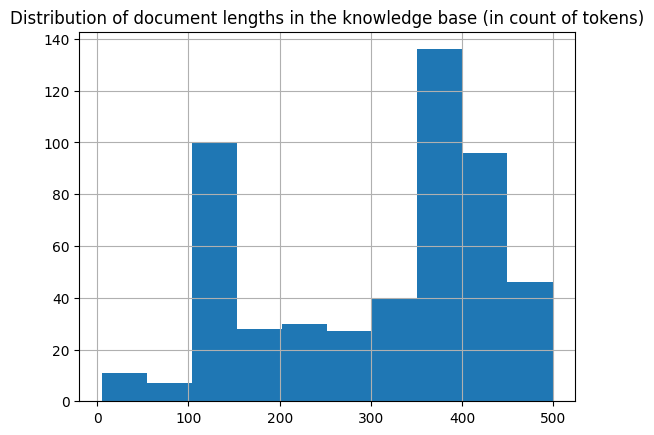

In [6]:
 v

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [7]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-7-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [21]:
########
# Assuming KNOWLEDGE_VECTOR_DATABASE is a FAISS vector store
# You can access the underlying FAISS index and its embeddings like this:

# Step 1: Access the FAISS index
faiss_index = KNOWLEDGE_VECTOR_DATABASE.index

# Step 2: Get the number of stored embeddings
num_embeddings = faiss_index.ntotal  # Number of vectors stored in the FAISS index

# Step 3: Retrieve all embeddings from the FAISS index
# The embeddings are stored in a matrix, where each row is an embedding vector
embeddings = faiss_index.reconstruct_n(0, num_embeddings)  # Retrieves all embeddings

# Step 4: Print the embeddings for inspection
print(f"Total embeddings in the corpus: {num_embeddings}\n")

for i, embedding in enumerate(embeddings):
    print(f"Embedding {i+1}: {embedding}\n")


Streaming output truncated to the last 5000 lines.
  4.72493237e-03 -3.73023860e-02  2.27541365e-02 -7.53319189e-02
 -1.54481586e-02 -2.41510961e-02  2.09825393e-02 -3.17897648e-01
  8.84539168e-03  2.55844221e-02  2.09774580e-02 -7.16958195e-02
  3.60807870e-03 -1.01360148e-02  2.41774619e-02 -3.58138867e-02
 -7.91879557e-03  7.68236071e-02  6.02492038e-03  3.68067734e-02
 -3.54362512e-03  2.55857818e-02  5.38420565e-02  7.51285926e-02
 -4.86249477e-02  3.37034054e-02 -2.37782300e-02  4.17069681e-02
  5.15701547e-02  2.14129388e-01  2.62436420e-02  9.32538044e-03
 -3.77956824e-03  8.72070808e-03 -1.21858597e-04  9.10206232e-03
 -1.51160751e-02  4.28710505e-02  1.75493956e-02  5.34990542e-02
 -6.14937879e-02  9.72270593e-03  4.63428535e-02 -5.43428473e-02
  6.68640882e-02  1.53735131e-02  1.53263938e-02 -7.97554553e-02
  2.62046754e-02 -6.60012513e-02 -5.13444236e-03  9.38369334e-02
 -5.26700877e-02 -4.03937325e-02 -3.15930247e-02  1.55602740e-02
  3.98129113e-02  1.75170526e-02  3.182

In [9]:
# Embed a user query in the same space
user_query = "Who is Randy Jackson?"
query_vector = embedding_model.embed_query(user_query)

In [11]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=3)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Who is Randy Jackson?'...

==================================Top document==================================
Close This Modal
vocals
Randy Jackson
vocals
Randy Jackson is the lead singer/guitarist for the rock band Zebra. Randy's first foray into recording success began with the self-titled Zebra debut album, released on Atlantic Records in 1983. Critically acclaimed for its lush rock sounds, due in large part to Jackson's searing lead vocals and soaring guitar leads, the album sold 75,000 copies the first week. "Who's Behind The Door" and "Tell Me What You Want", written by Jackson, received serious notice in the press, and helped to form legions of Zebra fans almost instantly. The latest Zebra release, "Zebra IV", was also produced and engineered by Jackson.
Randy Jackson is the lead singer/guitarist for the rock band Zebra. Randy's first foray into recording success began with the self-titled Zebra debut album, released on Atlantic Records in 1983.

In [12]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [13]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': " 8.\n\nWhat is 9-2? Answer: 7.\n\nWhat is 1+1+1? Answer: 3.\n\nThese are simple arithmetic problems that most people can answer without much thought. But what if the numbers were larger, like 100+100 or 1,000-500? Would you still be able to answer quickly and accurately?\n\nThe ability to perform basic arithmetic operations with large numbers is a fundamental skill in mathematics, and it's essential for many everyday tasks, such as calculating discounts, tips, and interest rates. In this article, we will explore the concept of large numbers in arithmetic, including strategies for mental calculation, common mistakes to avoid, and real-life applications.\n\nStrategies for Mental Calculation\n\nWhile it may not always be necessary to calculate large numbers mentally, it's a useful skill to have, especially when a calculator is not available. Here are some strategies for mental calculation:\n\n1. Rounding: One effective strategy for working with large numbers is roundi

In [16]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

In [19]:
# final_prompt = RAG_PROMPT_TEMPLATE.format(question="Who is Randy Jackson?", context=context)
final_prompt = RAG_PROMPT_TEMPLATE.format(question="Where is Heinz Hall?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Answer: Heinz Hall is located at 600 Penn Avenue, Pittsburgh, PA 15222, as mentioned in Document 0.
